In [ ]:
!pip install langgraph langsmith langchain langchain_groq langchain_community
!pip install arxiv wikipedia
!pip install --upgrade duckduckgo-search

In [7]:
from typing import Annotated
from typing_extensions import TypedDict

In [8]:
## Working With Tools
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper, DuckDuckGoSearchAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun, DuckDuckGoSearchRun

## Arxiv, Wikipedia and DuckDuckGo tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

ddg_wrapper = DuckDuckGoSearchAPIWrapper()
ddg_tool = DuckDuckGoSearchRun(api_wrapper=ddg_wrapper)

In [9]:
# Using both Wikipedia and DuckDuckGo tools
wiki_result = wiki_tool.invoke("who is Sharukh Khan")
ddg_result = ddg_tool.invoke("who is Sharukh Khan")

print("Wikipedia result:")
print(wiki_result)
print("\nDuckDuckGo result:") 
print(ddg_result)

Wikipedia result:
Page: Shah Rukh Khan
Summary: Shah Rukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10

DuckDuckGo result:
Shah Rukh Khan's family includes his parents, Taj Mohammad Khan and Lateef Fatima, wife Gauri Khan, children Aryan, Suhana, and Abram, and his siblings Shehnaz Lalarukh Khan. Each member of Shah Rukh Khan's family has played a unique role in his life and career, and together they form the foundation of the man we know today. Shah Rukh Khan is the most versatile of today's Bollywood action heroes, but nothing captures the complexity of SRK's stardom like his mid-career role in 'Om Shanti Om.' Shah Rukh Khan is a celebrated Indian hero whose home entrance gets crowded by hundreds of people on his birthday every year. People wait in anticipation to get jus

In [22]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [5]:
tools=[ddg_tool]

In [10]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [11]:
from langgraph.graph import StateGraph,START,END

In [12]:
graph_builder= StateGraph(State)

In [13]:
from langchain_groq import ChatGroq

In [5]:
from dotenv import load_dotenv
import os

load_dotenv()
groq_api_key = os.getenv('GROQ_API_KEY')


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


In [15]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x70ef3cf68a60>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x70ef3cf47010>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [16]:
llm_with_tools=llm.bind_tools(tools=tools)

In [17]:
llm_with_tools=llm.bind_tools(tools=tools)

In [18]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [19]:
from langgraph.prebuilt import ToolNode,tools_condition

In [20]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")

In [21]:
graph=graph_builder.compile()

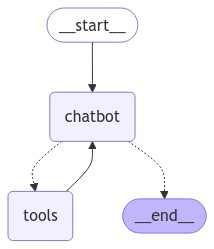

In [37]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
# Let's check which tools were used in the previous interactions
print("Available tools:")
for tool in tools:
    print(f"- {tool.name}: {tool.description}")


Available tools:
- duckduckgo_search: A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query.


In [22]:
user_input="Hi there!, Tell me about dhaka city"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, Tell me about dhaka city
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_68cy)
 Call ID: call_68cy
  Args:
    query: dhaka city
================================= Tool Message =================================
Name: duckduckgo_search

Dhaka is the capital of Bangladesh and one of the largest metropolises in South Asia. Learn about its history, culture, economy, and attractions from Britannica's editors and articles. Discover the wild and vibrant city of Dhaka, the capital of Bangladesh, with this ultimate travel guide. Learn about its history, culture, and best places to visit, from Old Dhaka to Lalbagh Fort, and more. Dhaka is the bustling capital of Bangladesh and one of the most densely populated cities in the world. If you plan on travelling to Bangladesh and visiting this unique city, this post is for you. It includes t

In [24]:
user_input = "what is the price of apple 16 pro in dhaka?."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is the price of apple 16 pro in dhaka?.
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_1xcf)
 Call ID: call_1xcf
  Args:
    query: price of apple 16 pro in Dhaka
================================= Tool Message =================================
Name: duckduckgo_search

iPhone 16 Pro. ৳ 153,000 - ৳ 179,000. or Buy Now @ ৳ 13,834 per month for 12 months on EMI*. Apple iPhone 16 pro price starts from ৳ 153,000 in Bangladesh. It has a bigger display 6.3-inch than previous iPhone 15 pro model. Powered by new A18 Pro processor and features new Apple intelligence AI features. Now, the Apple iPhone 16 Pro's price is 198000 taka in Bangladesh. The iPhone 16 Pro has a Li-Ion, 4800 mAh non-removable battery with (Wired, PD2.0, 50% in 30 min (advertised); 25W wireless (MagSafe); 15W wireless (Qi2); 4.5W reverse wired) charging. This device is